# Aim of this notebook

* To construct the singular curve of universal type to finalize the solution of the optimal control problem

# Preamble

In [2]:
from sympy import *
init_printing(use_latex='mathjax')

# Plotting
%matplotlib inline
## Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
## Import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker
## Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.25,
        rc={"xtick.major.size": 6, "ytick.major.size": 6,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Times']})

import pandas as pd
pd.set_option('mode.chained_assignment',None)

import numpy as np
from scipy.optimize import fsolve, root
from scipy.integrate import ode
backend = 'dopri5'
import warnings

# Timer
import time

from copy import deepcopy

from itertools import cycle
palette_size = 10;
clrs = sns.color_palette("Reds",palette_size)
iclrs = cycle(clrs) # iterated colors

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Parameter values

* Birth rate and const of downregulation are defined below in order to fit some experim. data

In [3]:
d = .13 # death rate
α = .3 # low equilibrium point at expression of the main pathway (high equilibrium is at one)
θ = .45 # threshold value for the expression of the main pathway
κ = 40 # robustness parameter

* Symbolic variables - the list insludes μ & μbar, because they will be varied later

In [4]:
σ, φ0, φ, x, μ, μbar = symbols('sigma, phi0, phi, x, mu, mubar')

* Main functions

In [5]:
A = 1-σ*(1-θ)
Eminus = (α*A-θ)**2/2
ΔE = A*(1-α)*((1+α)*A/2-θ)
ΔEf = lambdify(σ,ΔE)

* Birth rate and cost of downregulation

In [6]:
b = (0.1*(exp(κ*(ΔEf(1)))+1)-0.14*(exp(κ*ΔEf(0))+1))/(exp(κ*ΔEf(1))-exp(κ*ΔEf(0))) # birth rate
χ = 1-(0.14*(exp(κ*ΔEf(0))+1)-b*exp(κ*ΔEf(0)))/b
b, χ

(0.140168330860362, 0.325961223954473)

In [7]:
c_relative = 0.2
c = c_relative*(b-d)/b+(1-c_relative)*χ/(exp(κ*ΔEf(0))+1) # cost of resistance
c

0.0154694776420055

* Hamiltonian *H* and a part of it ρ that includes the control variable σ

In [8]:
h = b*(χ/(exp(κ*ΔE)+1)*(1-x)+c*x)
H = -φ0 + φ*(b*(χ/(exp(κ*ΔE)+1)-c)*x*(1-x)+μ*(1-x)/(exp(κ*ΔE)+1)-μbar*exp(-κ*Eminus)*x) + h
ρ = (φ*(b*χ*x+μ)+b*χ)/(exp(κ*ΔE)+1)*(1-x)-φ*μbar*exp(-κ*Eminus)*x
H, ρ

⎛  ⎛                                                                        2 
⎜  ⎜                μ⋅(-x + 1)                         -20⋅(-0.165⋅σ - 0.15)  
⎜φ⋅⎜────────────────────────────────────────── - μ̅⋅x⋅ℯ                       
⎜  ⎜ 40⋅(-0.385⋅σ + 0.7)⋅(-0.3575⋅σ + 0.2)                                    
⎝  ⎝ℯ                                      + 1                                

                                                                              
    ⎛                                   0.045689440686899             ⎞       
+ x⋅⎜-0.00216833086036159 + ──────────────────────────────────────────⎟⋅(-x + 
    ⎜                        40⋅(-0.385⋅σ + 0.7)⋅(-0.3575⋅σ + 0.2)    ⎟       
    ⎝                       ℯ                                      + 1⎠       

  ⎞                                                                           
  ⎟                                        0.045689440686899⋅(-x + 1)         
1)⎟ - φ₀ + 0.00216833086036159⋅x + ───────────────

* Same but for no treatment (σ = 0)

In [9]:
h0 = h.subs(σ,0)
H0 = H.subs(σ,0)
ρ0 = ρ.subs(σ,0)
H0, ρ0

(φ⋅(0.00368423989943599⋅μ⋅(-x + 1) - 0.637628151621773⋅μ̅⋅x - 0.002⋅x⋅(-x + 1)
) - φ₀ + 0.002⋅x + 0.000168330860361587, -0.637628151621773⋅μ̅⋅φ⋅x + 0.0036842
3989943599⋅(-x + 1)⋅(φ⋅(μ + 0.045689440686899⋅x) + 0.045689440686899))

* Machinery: definition of the Poisson brackets

In [10]:
PoissonBrackets = lambda H1, H2: diff(H1,x)*diff(H2,φ)-diff(H1,φ)*diff(H2,x)

* Necessary functions and defining the right hand side of dynamical equations

In [11]:
ρf = lambdify((x,φ,σ,μ,μbar),ρ)
ρ0f = lambdify((x,φ,μ,μbar),ρ0)
dxdτ = lambdify((x,φ,σ,μ,μbar),-diff(H,φ))
dφdτ = lambdify((x,φ,σ,μ,μbar),diff(H,x))
dVdτ = lambdify((x,σ),h)
dρdσ = lambdify((σ,x,φ,μ,μbar),diff(ρ,σ))
dδρdτ = lambdify((x,φ,σ,μ,μbar),-PoissonBrackets(ρ0-ρ,H))
def ode_rhs(t,state,μ,μbar):
    x, φ, V, δρ = state
    σs = [0,1]
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return [dxdτ(x,φ,sgm,μ,μbar),dφdτ(x,φ,sgm,μ,μbar),dVdτ(x,sgm),dδρdτ(x,φ,σstar,μ,μbar)]

In [12]:
def get_primary_field(name, experiment,μ,μbar):
    solutions = {}
    solver = ode(ode_rhs).set_integrator(backend)
    τ0 = experiment['τ0']
    tms = np.linspace(τ0,experiment['T_end'],1e3+1)
    for x0 in experiment['x0']:
        δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
        solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
        sol = []; k = 0;
        while (solver.t < experiment['T_end']) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
            solver.integrate(tms[k])
            sol.append([solver.t]+list(solver.y))
            k += 1
        solutions[x0] = {'solution': sol}
    for x0, entry in solutions.items():
        entry['τ'] = [entry['solution'][j][0] for j in range(len(entry['solution']))]
        entry['x'] = [entry['solution'][j][1] for j in range(len(entry['solution']))]
        entry['φ'] = [entry['solution'][j][2] for j in range(len(entry['solution']))]
        entry['V'] = [entry['solution'][j][3] for j in range(len(entry['solution']))]
        entry['δρ'] = [entry['solution'][j][4] for j in range(len(entry['solution']))]
    return solutions
def get_δρ_value(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    while (solver.t < tme) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tme)
        sol = [solver.t]+list(solver.y)
    return solver.y[3]
def get_δρ_ending(params,μ,μbar):
    tme, x0 = params
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (_k<len(tms)):# and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    #print(sol)
    return(sol[0][3],(sol[1][3]-sol[0][3])/δτ)
def get_state(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (solver.t < tms[-1]) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    return(list(sol[0])+[(sol[1][3]-sol[0][3])/δτ])

# Machinery for the universal line

* To find the universal singular curve we need to define two parameters

In [13]:
γ0 = PoissonBrackets(PoissonBrackets(H,H0),H)
γ1 = PoissonBrackets(PoissonBrackets(H0,H),H0)

* The dynamics

In [14]:
dxdτSingExpr = -(γ0*diff(H0,φ)+γ1*diff(H,φ))/(γ0+γ1)
dφdτSingExpr = (γ0*diff(H0,x)+γ1*diff(H,x))/(γ0+γ1)
dVdτSingExpr = (γ0*h0+γ1*h)/(γ0+γ1)
σSingExpr = γ1*σ/(γ0+γ1)

* Machinery for Python: lambdify the functions above

In [15]:
dxdτSing = lambdify((x,φ,σ,μ,μbar),dxdτSingExpr)
dφdτSing = lambdify((x,φ,σ,μ,μbar),dφdτSingExpr)
dVdτSing = lambdify((x,φ,σ,μ,μbar),dVdτSingExpr)
σSing = lambdify((x,φ,σ,μ,μbar),σSingExpr)

In [16]:
def ode_rhs_Sing(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    #print([σstar,σSing(x,φ,σstar,μ,μbar)])
    return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτSing(x,φ,σstar,μ,μbar)]
# def ode_rhs_Sing(t,state,μ,μbar):
#     x, φ, V = state
#     if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
#         σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
#     else:
#         σstar = 1.;
#     σTrav = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-dxdτSing(x,φ,σstar,μ,μbar),.6)[0]
#     print([σstar,σTrav])
#     return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτ(x,σTrav)]
def get_universal_curve(end_point,tmax,Nsteps,μ,μbar):
    tms =  np.linspace(end_point[0],tmax,Nsteps);
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tms[-1]):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_σ_universal(tme,end_point,μ,μbar):
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tme+δτ):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    x, φ = sol[0][:2]
    sgm = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-(sol[1][0]-sol[0][0])/δτ,θ/2)[0]
    return sgm
def get_state_universal(tme,end_point,μ,μbar):
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)

In [17]:
def ode_rhs_with_σstar(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σ = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σ = 1.;
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def ode_rhs_with_given_σ(t,state,σ,μ,μbar):
    x, φ, V = state
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def get_trajectory_with_σstar(starting_point,tmax,Nsteps,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,Nsteps)
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_trajectory_with_given_σ(starting_point,tmax,Nsteps,σ,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,100)
    solver = ode(ode_rhs_with_given_σ).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(σ,μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_state_with_σstar(tme,starting_point,μ,μbar):
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:4],starting_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)
def get_finalizing_point_from_universal_curve(tme,tmx,end_point,μ,μbar):
    unv_point = get_state_universal(tme,end_point,μ,μbar)
    return get_state_with_σstar(tmx,unv_point,μ,μbar)[1]

# Field of optimal trajectories as the solution of the Bellman equation

* μ & μbar are varied by *T* and *T*bar ($\mu=1/T$ and $\bar\mu=1/\bar{T}$)

Parameters: μ = 0.03571, μbar = 0.01667
Ending point for the switching line: τ = 25.5 days, x = 71.6%
Checking the solution - should give zero values: 
(-4.204122433017251e-08, -9.106111013088652e-08)
* Constructing the primary field
* Constructing the switching curve
* Constructing the universal curve
* Finding the last characteristic
[149.95741812]
The last point on the universal line:
[149.95741811739222, 0.7158075555993243, -0.4989833791879546, 0.904905603294865]
Final state:
[180.0, 1.205036070928145e-12, -1.1012177672839152, 1.6210541658554904]
Fold-change in tumor size: 1.23


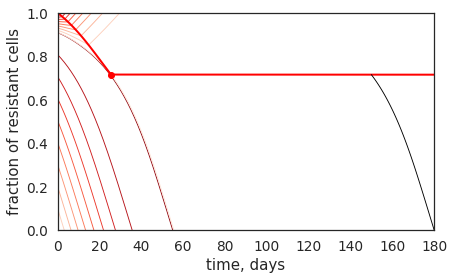

In [18]:
tmx = 180.
end_switching_curve = {'t': 24., 'x': .9/.8} 
# for Τ, Τbar in zip([28]*5,[14,21,28,35,60]):
for Τ, Τbar in zip([28],[60]):
    μ = 1./Τ; μbar = 1./Τbar
    print("Parameters: μ = %.5f, μbar = %.5f"%(μ,μbar))
    end_switching_curve['t'], end_switching_curve['x'] = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar)).x
    end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
    print("Ending point for the switching line: τ = %.1f days, x = %.1f%%" % (end_point[0], end_point[1]*100))
    print("Checking the solution - should give zero values: ")
    print(get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar))
    print("* Constructing the primary field")
    experiments = {
        'sol1': { 'T_end': tmx, 'τ0': 0., 'x0': list(np.linspace(0,end_switching_curve['x']-(1e-3),10))+list(np.linspace(end_switching_curve['x']+(1e-6),1.,10)) } }
    primary_field = []
    for name, values in experiments.items():
        primary_field.append(get_primary_field(name,values,μ,μbar))
    print("* Constructing the switching curve")
    switching_curve = []
    x0s = np.linspace(end_switching_curve['x'],1,21); _y = end_switching_curve['t']
    
    for x0 in x0s:
        tme = fsolve(get_δρ_value,_y,args=(x0,μ,μbar))[0]
        if (tme>0):
            switching_curve = switching_curve+[[tme,get_state(tme,x0,μ,μbar)[0]]]
            _y = tme
    print("* Constructing the universal curve")
    universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
    print("* Finding the last characteristic")
    #time0 = time.time()
#     tuniv = fsolve(get_finalizing_point_from_universal_curve,tmx-40.,args=(tmx,end_point,μ,μbar,))[0]
    tuniv = root(get_finalizing_point_from_universal_curve,tmx-40,args=(tmx,end_point,μ,μbar)).x
    print(tuniv)
    #print("The proccess to find the last characteristic took %0.1f minutes" % ((time.time()-time0)/60.))
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    print("The last point on the universal line:")
    print(univ_point)
    last_trajectory = get_trajectory_with_σstar(univ_point,tmx,50,μ,μbar)
    print("Final state:")
    final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
    print(final_state)
    print("Fold-change in tumor size: %.2f"%(exp((b-d)*tmx-final_state[-1])))
    # Plotting
    plt.rcParams['figure.figsize'] = (6.75, 4)
    _k = 0
    for solutions in primary_field:
        for x0, entry in solutions.items():
            plt.plot(entry['τ'], entry['x'], 'k-', linewidth=.9, color=clrs[_k%palette_size])
            _k += 1
    plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=2,color="red")
    plt.plot([end_point[0]],[end_point[1]],marker='o',color="red")
    plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=2,color="red")
    plt.plot([x[0] for x in last_trajectory],[x[1] for x in last_trajectory],linewidth=.9,color="black")
    plt.xlim([0,tmx]); plt.ylim([0,1]);
    plt.xlabel("time, days"); plt.ylabel("fraction of resistant cells")
    plt.show()
    print()

In [20]:
import csv
from numpy.linalg import norm
File = open("../figures/draft/sensitivity_mu-high_cost.csv", 'w')
File.write("T,Tbar,mu,mubar,sw_start_x,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
writer = csv.writer(File,lineterminator='\n')

end_switching_curve0 = {'t': 40.36, 'x': .92}
end_switching_curve_prev_t = end_switching_curve0['t']
tuniv = tmx-30.
Ts = np.arange(40,3,-1) #Τbars; 
Τbars = np.arange(40,3,-1) #np.arange(120,1,-1) #need to change here if more
for Τ in Ts:
    μ = 1./Τ
    end_switching_curve = deepcopy(end_switching_curve0)
    for Τbar in Τbars:
        μbar = 1./Τbar
        print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
        success = False; err = 1.
        while (not success)|(norm(err)>1e-6):
            end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                                   'x': end_switching_curve['x']-0.002} 
            sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
            end_switching_curve_prev_t = end_switching_curve['t']
            end_switching_curve_prev_x = end_switching_curve['x']
            end_switching_curve['t'], end_switching_curve['x'] = sol.x 
            success = sol.success
            err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
            if (not success): 
                print("! Trying again...", sol.message)
            elif (norm(err)>1e-6):
                print("! Trying again... Convergence is not sufficient")       
        else:
            end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
            print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
            universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
            tuniv = root(get_finalizing_point_from_universal_curve,tuniv,args=(tmx,end_point,μ,μbar)).x
            err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
            univ_point = get_state_universal(tuniv,end_point,μ,μbar)
            print("tuniv = %.2f"%tuniv,"xuniv = %.2f%%"%(100*univ_point[1])," Checking the solution: ",err_tuniv)
            final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
            outcome = exp((b-d)*tmx-final_state[-1])
            print("Fold-change in tumor size: %.2f"%(outcome))
            output = [Τ,Τbar,μ,μbar,end_switching_curve['x'],end_point[0],end_point[1]]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
            writer.writerow(output)
        if (Τbar==Τ):
            end_switching_curve0 = deepcopy(end_switching_curve) 

File.close()

* Parameters: T = 40.0, Tbar = 40.0 (μ = 0.02500, μbar = 0.02500)
Ending point: t = 28.42, x = 85.61%  Checking the solution: (-6.431459309685764e-13, -2.564424486853651e-14)
tuniv = 148.30 xuniv = 61.46%  Checking the solution:  -8.813713647803922e-13
Fold-change in tumor size: 0.79
* Parameters: T = 40.0, Tbar = 39.0 (μ = 0.02500, μbar = 0.02564)
Ending point: t = 28.31, x = 85.33%  Checking the solution: (2.133514435304388e-13, 5.494313463620051e-14)
tuniv = 148.49 xuniv = 61.10%  Checking the solution:  5.130570968070458e-11
Fold-change in tumor size: 0.78
* Parameters: T = 40.0, Tbar = 38.0 (μ = 0.02500, μbar = 0.02632)
! Trying again... Convergence is not sufficient
Ending point: t = 28.19, x = 85.04%  Checking the solution: (-1.06787083939652e-13, -3.9119905115077993e-14)
tuniv = 148.69 xuniv = 60.73%  Checking the solution:  -8.631248493706778e-12
Fold-change in tumor size: 0.76
* Parameters: T = 40.0, Tbar = 37.0 (μ = 0.02500, μbar = 0.02703)
! Trying again... Convergence is n

Ending point: t = 23.65, x = 69.10%  Checking the solution: (-1.250972538647702e-07, 2.1720820826186482e-07)
tuniv = 155.15 xuniv = 45.63%  Checking the solution:  -1.2406742300186124e-14
Fold-change in tumor size: 0.32
* Parameters: T = 40.0, Tbar = 12.0 (μ = 0.02500, μbar = 0.08333)
Ending point: t = 23.38, x = 67.61%  Checking the solution: (5.635466492602288e-13, 5.844688369702243e-14)
tuniv = 155.57 xuniv = 44.50%  Checking the solution:  2.131897436363772e-11
Fold-change in tumor size: 0.29
* Parameters: T = 40.0, Tbar = 11.0 (μ = 0.02500, μbar = 0.09091)
! Trying again... Convergence is not sufficient
Ending point: t = 23.13, x = 65.94%  Checking the solution: (-1.3167366570516808e-07, -9.327850990555137e-07)
tuniv = 156.16 xuniv = 43.14%  Checking the solution:  3.3465452631276094e-12
Fold-change in tumor size: 0.27
* Parameters: T = 40.0, Tbar = 10.0 (μ = 0.02500, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement fro

! Trying again... Convergence is not sufficient
Ending point: t = 26.48, x = 81.47%  Checking the solution: (-1.1122994669004882e-07, -2.0695277405834012e-07)
tuniv = 151.25 xuniv = 56.59%  Checking the solution:  -3.441552598459907e-13
Fold-change in tumor size: 0.64
* Parameters: T = 39.0, Tbar = 27.0 (μ = 0.02564, μbar = 0.03704)
! Trying again... Convergence is not sufficient
Ending point: t = 26.31, x = 80.99%  Checking the solution: (-1.5322845852726125e-07, 3.0382140081769773e-08)
tuniv = 151.40 xuniv = 56.16%  Checking the solution:  -1.33809630042947e-12
Fold-change in tumor size: 0.62
* Parameters: T = 39.0, Tbar = 26.0 (μ = 0.02564, μbar = 0.03846)
! Trying again... Convergence is not sufficient
Ending point: t = 26.14, x = 80.48%  Checking the solution: (5.23058122995149e-13, 5.229912026867956e-14)
tuniv = 151.66 xuniv = 55.61%  Checking the solution:  -2.1422585927410864e-12
Fold-change in tumor size: 0.61
* Parameters: T = 39.0, Tbar = 25.0 (μ = 0.02564, μbar = 0.04000)
E

! Trying again... Convergence is not sufficient
Ending point: t = 22.23, x = 44.64%  Checking the solution: (-3.980447942312814e-07, -6.356775751923072e-07)
tuniv = 157.61 xuniv = 31.16%  Checking the solution:  -2.6006974351844292e-14
Fold-change in tumor size: 0.08
* Parameters: T = 38.0, Tbar = 40.0 (μ = 0.02632, μbar = 0.02500)
Ending point: t = 27.75, x = 85.90%  Checking the solution: (4.9948743888395724e-14, -2.8602733271669666e-15)
tuniv = 148.98 xuniv = 62.14%  Checking the solution:  -1.531878790483887e-11
Fold-change in tumor size: 0.82
* Parameters: T = 38.0, Tbar = 39.0 (μ = 0.02632, μbar = 0.02564)
Ending point: t = 27.64, x = 85.62%  Checking the solution: (-1.279759184705958e-13, 4.999333411634882e-16)
tuniv = 149.16 xuniv = 61.77%  Checking the solution:  -1.7548601460859459e-12
Fold-change in tumor size: 0.81
* Parameters: T = 38.0, Tbar = 38.0 (μ = 0.02632, μbar = 0.02632)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement 

Ending point: t = 23.59, x = 72.17%  Checking the solution: (-1.3957409699437682e-07, -5.883432009308316e-07)
tuniv = 155.29 xuniv = 48.06%  Checking the solution:  -2.340488913787908e-12
Fold-change in tumor size: 0.39
* Parameters: T = 38.0, Tbar = 14.0 (μ = 0.02632, μbar = 0.07143)
Ending point: t = 23.31, x = 70.96%  Checking the solution: (-1.977751563729665e-12, 1.0761183560788739e-14)
tuniv = 155.47 xuniv = 47.26%  Checking the solution:  -1.9774029635932777e-11
Fold-change in tumor size: 0.36
* Parameters: T = 38.0, Tbar = 13.0 (μ = 0.02632, μbar = 0.07692)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 23.07, x = 69.64%  Checking the solution: (-1.5796032036378526e-07, -5.800238497871807e-07)
tuniv = 155.96 xuniv = 46.11%  Checking the solution:  -5.41836020495623e-12
Fold-change in tumor size: 0.34
* Parameters: T = 38.0, Tbar = 12.0 

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 26.57, x = 83.88%  Checking the solution: (-2.3427016080235407e-07, -4.0293346183579634e-07)
tuniv = 150.89 xuniv = 59.56%  Checking the solution:  -1.379167960391392e-11
Fold-change in tumor size: 0.74
* Parameters: T = 37.0, Tbar = 32.0 (μ = 0.02703, μbar = 0.03125)
! Trying again... Convergence is not sufficient
Ending point: t = 26.42, x = 83.51%  Checking the solution: (-2.3917006870675225e-07, -2.0379534360390845e-07)
tuniv = 151.02 xuniv = 59.20%  Checking the solution:  -1.1582683423494444e-10
Fold-change in tumor size: 0.73
* Parameters: T = 37.0, Tbar = 31.0 (μ = 0.02703, μbar = 0.03226)
Ending point: t = 26.31, x = 83.13%  Checking the solution: (-2.499532243891743e-07, -6.588986605099727e-07)
tuniv = 151.42 xuniv = 58.56%  Checking the solution:  9.875711359796924e-13
Fold-ch

! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 21.91, x = 64.98%  Checking the solution: (-1.1763824739376262e-07, -1.123579926875079e-07)
tuniv = 157.24 xuniv = 43.05%  Checking the solution:  -8.197872936044348e-12
Fold-change in tumor size: 0.26
* Parameters: T = 37.0, Tbar = 9.0 (μ = 0.02703, μbar = 0.11111)
Ending point: t = 21.63, x = 62.90%  Chec

! Trying again... Convergence is not sufficient
Ending point: t = 25.01, x = 80.53%  Checking the solution: (-1.4907549958842411e-07, -3.9329033583844096e-07)
tuniv = 153.04 xuniv = 55.98%  Checking the solution:  -1.996666720849305e-12
Fold-change in tumor size: 0.63
* Parameters: T = 36.0, Tbar = 24.0 (μ = 0.02778, μbar = 0.04167)
! Trying again... Convergence is not sufficient
Ending point: t = 24.82, x = 79.97%  Checking the solution: (-2.177697942227855e-07, -1.3575031762686168e-08)
tuniv = 153.15 xuniv = 55.53%  Checking the solution:  1.3467754689244771e-11
Fold-change in tumor size: 0.61
* Parameters: T = 36.0, Tbar = 23.0 (μ = 0.02778, μbar = 0.04348)
Ending point: t = 24.64, x = 79.37%  Checking the solution: (-2.162673530155583e-07, -2.5457088185783325e-08)
tuniv = 153.42 xuniv = 54.92%  Checking the solution:  8.990197475355899e-12
Fold-change in tumor size: 0.59
* Parameters: T = 36.0, Tbar = 22.0 (μ = 0.02778, μbar = 0.04545)
! Trying again... The iteration is not making 

Ending point: t = 26.35, x = 85.52%  Checking the solution: (-4.4978893421710154e-13, -1.9852577039342748e-14)
tuniv = 150.61 xuniv = 62.10%  Checking the solution:  -2.3409428041853975e-11
Fold-change in tumor size: 0.83
* Parameters: T = 35.0, Tbar = 36.0 (μ = 0.02857, μbar = 0.02778)
Ending point: t = 26.23, x = 85.22%  Checking the solution: (-8.339503748350252e-09, -1.2583835131298166e-08)
tuniv = 150.81 xuniv = 61.70%  Checking the solution:  -9.439254933241159e-12
Fold-change in tumor size: 0.82
* Parameters: T = 35.0, Tbar = 35.0 (μ = 0.02857, μbar = 0.02857)
Ending point: t = 26.17, x = 84.91%  Checking the solution: (-1.2674473759946143e-07, -8.297039845833913e-07)
tuniv = 151.38 xuniv = 60.93%  Checking the solution:  -1.0000167360857404e-11
Fold-change in tumor size: 0.81
* Parameters: T = 35.0, Tbar = 34.0 (μ = 0.02857, μbar = 0.02941)
Ending point: t = 26.03, x = 84.58%  Checking the solution: (-1.5412672218501242e-07, -6.376237445616982e-07)
tuniv = 151.49 xuniv = 60.61%

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 20.99, x = 63.58%  Checking the solution: (-1.130245367732789e-12, -1.3172200981085574e-13)
tuniv = 158.22 xuniv = 42.40%  Checking the solution:  -1.4367049216978955e-11
Fold-change in tumor size: 0.24
* Parameters: T = 35.0, Tbar = 8.0 (μ = 0.02857, μbar = 0.12500)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 20.71, x = 61.21%  Checking the solution: (-1.1382794028585308e-11, -1.3477452437543949e-12)
tuniv = 158.59 xuniv = 40.87%  Checking the solution:  1.179820130481346e-12
Fold-change in 

Ending point: t = 23.42, x = 77.81%  Checking the solution: (-1.7031744870142847e-07, -8.952085496403636e-07)
tuniv = 155.18 xuniv = 53.43%  Checking the solution:  1.0368428338125568e-11
Fold-change in tumor size: 0.55
* Parameters: T = 34.0, Tbar = 19.0 (μ = 0.02941, μbar = 0.05263)
Ending point: t = 23.18, x = 77.04%  Checking the solution: (-1.8344557779293238e-13, -2.0111992370302867e-14)
tuniv = 155.19 xuniv = 52.99%  Checking the solution:  1.0897505120510687e-11
Fold-change in tumor size: 0.53
* Parameters: T = 34.0, Tbar = 18.0 (μ = 0.02941, μbar = 0.05556)
Ending point: t = 22.97, x = 76.21%  Checking the solution: (-2.531592008131319e-13, 1.1682424666018954e-13)
tuniv = 155.48 xuniv = 52.23%  Checking the solution:  -2.976618951322507e-12
Fold-change in tumor size: 0.51
* Parameters: T = 34.0, Tbar = 17.0 (μ = 0.02941, μbar = 0.05882)
Ending point: t = 22.75, x = 75.31%  Checking the solution: (-1.352719544993504e-13, 5.918331627539373e-14)
tuniv = 155.78 xuniv = 51.43%  Che

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... Convergence is not sufficient
Ending point: t = 24.85, x = 83.88%  Checking the solution: (-2.204250635611445e-07, -4.3271673374198957e-08)
tuniv = 152.59 xuniv = 60.33%  Checking the solution:  4.521695518011626e-13
Fold-change in tumor size: 0.78
* Parameters: T = 33.0, Tbar = 30.0 (μ = 0.03030, μbar = 0.03333)
! Trying again... Convergence is not sufficient
Ending point: t = 24.71, x = 83.49%  Checking the solution: (-2.0590050349349e-07, -6.984088405599166e-09)
tuniv = 152.79 xuniv = 59.88%  Checking the solution:  3.241268364817529e-12
Fold-change in tumor size: 0.77
* Parameters: T = 33.0, Tbar = 29.0 (μ = 0.03030, μbar = 0.03448)
! Trying again... Convergence is not sufficient
Ending point: t = 24.59, x = 83.07%  Checking the solution: (-1.7722172266982663e-07, -3.245745232946398e-07)
tuniv = 153.14 xuniv = 59.27%  Checking the

Ending point: t = 19.77, x = 59.23%  Checking the solution: (-5.8122729293397674e-12, -8.162714412107744e-13)
tuniv = 159.61 xuniv = 39.89%  Checking the solution:  -2.562713929954441e-12
Fold-change in tumor size: 0.19
* Parameters: T = 33.0, Tbar = 6.0 (μ = 0.03030, μbar = 0.16667)
Ending point: t = 19.55, x = 55.99%  Checking the solution: (-8.637405481117872e-08, -9.568270519432973e-08)
tuniv = 159.94 xuniv = 37.94%  Checking the solution:  3.240396839743198e-11
Fold-change in tumor size: 0.16
* Parameters: T = 33.0, Tbar = 5.0 (μ = 0.03030, μbar = 0.20000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 19.45, x = 52.07%  Checking the solution: (-5.506338528855296e-12, -7.284875449384379e-13)
tuniv = 160.11 xuniv = 35.72%  Checking the solution:  8.607697887796917e-13
Fold-change in tumor size: 0.12
* Parameters: T = 33.0, Tbar = 4.0 (μ = 0.03030, μbar = 0.25000)
! Trying again... Conver

Ending point: t = 21.83, x = 74.91%  Checking the solution: (-5.941580479053941e-08, 4.6155733871071654e-08)
tuniv = 156.77 xuniv = 51.41%  Checking the solution:  -1.4539702775095975e-11
Fold-change in tumor size: 0.48
* Parameters: T = 32.0, Tbar = 15.0 (μ = 0.03125, μbar = 0.06667)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 21.59, x = 73.86%  Checking the solution: (-1.528463126847117e-07, 2.506716636233326e-07)
tuniv = 157.03 xuniv = 50.56%  Checking the solution:  -9.080794449722873e-10
Fold-change in tumor size: 0.45
* Parameters: T = 32.0, Tbar = 14.0 (μ = 0.03125, μbar = 0.07143)
! Trying again... Convergence is not sufficient
Ending point: t = 21.35, x = 72.71%  Checking the solution: (-1.0187856408624022e-07, 1.1926290071789553e-09)
tuniv = 157

Ending point: t = 23.83, x = 83.50%  Checking the solution: (-1.6986079933747582e-07, -2.947343731260385e-07)
tuniv = 153.88 xuniv = 60.11%  Checking the solution:  -1.739886013041314e-12
Fold-change in tumor size: 0.79
* Parameters: T = 31.0, Tbar = 28.0 (μ = 0.03226, μbar = 0.03571)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 23.69, x = 83.08%  Checking the solution: (-1.242626015919165e-07, -4.0186554122474384e-07)
tuniv = 154.14 xuniv = 59.57%  Checking the solution:  -7.933931289727525e-14
Fold-change in tumor size: 0.77
* Parameters: T = 31.0, Tbar = 27.0 (μ = 0.03226, μbar = 0.03704)
Ending point: t = 23.54, x = 82.63%  Checking the solution: (-5.060730000275794e-08, -3.2555265179583847e-07)
tuniv = 154.34 xuniv = 59.08%  Checking the solution:  -6.453920731175344e-12
Fold-change in tumor size: 0.75
* Parameters: T = 31.0, Tbar = 26.0 (μ = 0.03226, μbar = 0.03846)
Ending

Ending point: t = 24.74, x = 87.21%  Checking the solution: (-1.754499255840307e-13, -1.9888602108073657e-14)
tuniv = 152.01 xuniv = 65.21%  Checking the solution:  2.573496971081113e-13
Fold-change in tumor size: 0.98
* Parameters: T = 30.0, Tbar = 39.0 (μ = 0.03333, μbar = 0.02564)
Ending point: t = 24.64, x = 86.96%  Checking the solution: (-5.896323316075978e-14, -1.240451587935108e-15)
tuniv = 152.19 xuniv = 64.85%  Checking the solution:  -1.41334166592344e-12
Fold-change in tumor size: 0.96
* Parameters: T = 30.0, Tbar = 38.0 (μ = 0.03333, μbar = 0.02632)
Ending point: t = 24.53, x = 86.70%  Checking the solution: (-2.9722256544288293e-13, -1.8105329651457453e-15)
tuniv = 152.37 xuniv = 64.49%  Checking the solution:  -2.5578580920004867e-11
Fold-change in tumor size: 0.95
* Parameters: T = 30.0, Tbar = 37.0 (μ = 0.03333, μbar = 0.02703)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 20.65, x = 73.37%  Checking the solution: (-1.207762847430513e-07, 2.3458339246191433e-09)
tuniv = 158.14 xuniv = 50.40%  Checking the solution:  -3.6202985054245573e-13
Fold-change in tumor size: 0.45
* Parameters: T = 30.0, Tbar = 13.0 (μ = 0.03333, μbar = 0.07692)
! Trying again... Convergence is not sufficient
Ending point: t = 20.39, x = 72.13%  Checking the solution: (-2.122459008962133e-12, -2.6278950488409323e-13)
tuniv = 158.47 xuniv = 49.37%  Checking the solution:  -2.67796895769834e-12
Fold-change in tumor size: 0.42
* Parameters: T = 30.0, Tbar = 12.0 (μ = 0.03333, μbar = 0.08333)
! Trying again... The iteration is not making good progress, as measured

Fold-change in tumor size: 0.79
* Parameters: T = 29.0, Tbar = 26.0 (μ = 0.03448, μbar = 0.03846)
! Trying again... Convergence is not sufficient
Ending point: t = 22.59, x = 82.64%  Checking the solution: (8.698606268490642e-13, 5.355188702295245e-12)
tuniv = 155.23 xuniv = 59.56%  Checking the solution:  1.3393092190838729e-11
Fold-change in tumor size: 0.77
* Parameters: T = 29.0, Tbar = 25.0 (μ = 0.03448, μbar = 0.04000)
Ending point: t = 22.44, x = 82.15%  Checking the solution: (-3.3937981591421624e-08, -1.2263264924497935e-08)
tuniv = 155.46 xuniv = 59.00%  Checking the solution:  1.0599854327608682e-12
Fold-change in tumor size: 0.75
* Parameters: T = 29.0, Tbar = 24.0 (μ = 0.03448, μbar = 0.04167)
Ending point: t = 22.28, x = 81.63%  Checking the solution: (-1.6797614623618497e-07, -1.0017212275158737e-07)
tuniv = 155.73 xuniv = 58.39%  Checking the solution:  -6.803738128446923e-12
Fold-change in tumor size: 0.73
* Parameters: T = 29.0, Tbar = 23.0 (μ = 0.03448, μbar = 0.0434

tuniv = 153.23 xuniv = 65.37%  Checking the solution:  1.1107781361374691e-12
Fold-change in tumor size: 1.00
* Parameters: T = 28.0, Tbar = 37.0 (μ = 0.03571, μbar = 0.02703)
Ending point: t = 23.59, x = 86.83%  Checking the solution: (-5.479498707238957e-08, -9.884107201721481e-08)
tuniv = 153.45 xuniv = 64.95%  Checking the solution:  -1.848868280696081e-12
Fold-change in tumor size: 0.98
* Parameters: T = 28.0, Tbar = 36.0 (μ = 0.03571, μbar = 0.02778)
Ending point: t = 23.49, x = 86.55%  Checking the solution: (-8.677779670371686e-08, -1.9229027507585458e-07)
tuniv = 153.68 xuniv = 64.52%  Checking the solution:  -4.521172498883619e-12
Fold-change in tumor size: 0.97
* Parameters: T = 28.0, Tbar = 35.0 (μ = 0.03571, μbar = 0.02857)
Ending point: t = 23.42, x = 86.26%  Checking the solution: (-1.8406548989237015e-07, -8.844342931982668e-07)
tuniv = 154.17 xuniv = 63.80%  Checking the solution:  1.2827516826519059e-12
Fold-change in tumor size: 0.95
* Parameters: T = 28.0, Tbar = 34

Ending point: t = 19.13, x = 69.98%  Checking the solution: (-2.179994884506547e-08, -7.579869212257424e-09)
tuniv = 159.91 xuniv = 47.99%  Checking the solution:  -1.7004009311705204e-11
Fold-change in tumor size: 0.38
* Parameters: T = 28.0, Tbar = 10.0 (μ = 0.03571, μbar = 0.10000)
Ending point: t = 18.85, x = 68.27%  Checking the solution: (3.3065049393967204e-13, 4.3698991496573745e-14)
tuniv = 160.28 xuniv = 46.70%  Checking the solution:  -1.2246870184640102e-10
Fold-change in tumor size: 0.34
* Parameters: T = 28.0, Tbar = 9.0 (μ = 0.03571, μbar = 0.11111)
Ending point: t = 18.56, x = 66.31%  Checking the solution: (-1.2437460763636688e-07, -4.549165011425693e-07)
tuniv = 160.75 xuniv = 45.18%  Checking the solution:  9.550027435523134e-12
Fold-change in tumor size: 0.30
* Parameters: T = 28.0, Tbar = 8.0 (μ = 0.03571, μbar = 0.12500)
Ending point: t = 18.26, x = 64.06%  Checking the solution: (-7.794509373125786e-13, -1.0143672836730338e-13)
tuniv = 161.03 xuniv = 43.71%  Chec

! Trying again... Convergence is not sufficient
Ending point: t = 21.16, x = 81.06%  Checking the solution: (-1.9370707438860578e-07, -5.989970331106304e-07)
tuniv = 157.20 xuniv = 57.93%  Checking the solution:  -7.7712142276809e-12
Fold-change in tumor size: 0.72
* Parameters: T = 27.0, Tbar = 21.0 (μ = 0.03704, μbar = 0.04762)
Ending point: t = 20.97, x = 80.44%  Checking the solution: (-1.4578489761461145e-07, -2.732791265102716e-07)
tuniv = 157.34 xuniv = 57.40%  Checking the solution:  2.0434556824433514e-12
Fold-change in tumor size: 0.70
* Parameters: T = 27.0, Tbar = 20.0 (μ = 0.03704, μbar = 0.05000)
Ending point: t = 20.78, x = 79.77%  Checking the solution: (-3.9432342063135085e-13, -4.990742527050408e-14)
tuniv = 157.52 xuniv = 56.81%  Checking the solution:  -4.1130987504800487e-13
Fold-change in tumor size: 0.67
* Parameters: T = 27.0, Tbar = 19.0 (μ = 0.03704, μbar = 0.05263)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement 

Ending point: t = 22.37, x = 86.41%  Checking the solution: (-1.7642579777480142e-07, -3.526969753495042e-08)
tuniv = 154.86 xuniv = 64.76%  Checking the solution:  -1.2963033424462367e-12
Fold-change in tumor size: 0.99
* Parameters: T = 26.0, Tbar = 33.0 (μ = 0.03846, μbar = 0.03030)
! Trying again... Convergence is not sufficient
Ending point: t = 22.26, x = 86.10%  Checking the solution: (-1.8472243380056394e-07, -1.0075333558416959e-07)
tuniv = 155.08 xuniv = 64.31%  Checking the solution:  2.4627522243747535e-13
Fold-change in tumor size: 0.97
* Parameters: T = 26.0, Tbar = 32.0 (μ = 0.03846, μbar = 0.03125)
! Trying again... Convergence is not sufficient
Ending point: t = 22.15, x = 85.78%  Checking the solution: (-1.8703025399617599e-07, -2.2094500792872946e-07)
tuniv = 155.32 xuniv = 63.83%  Checking the solution:  -1.118410919431767e-12
Fold-change in tumor size: 0.96
* Parameters: T = 26.0, Tbar = 31.0 (μ = 0.03846, μbar = 0.03226)
Ending point: t = 22.02, x = 85.44%  Checki

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 17.79, x = 67.23%  Checking the solution: (-1.4867826403747007e-07, 1.9250526262577956e-07)
tuniv = 161.37 xuniv = 46.29%  Checking the solution:  4.147335253001927e-12
Fold-change in tumor size: 0.33
* Parameters: T = 26.0, Tbar = 8.0 (μ = 0.03846, μbar = 0.12500)
Ending point: t = 17.50, x = 65.01%  Checking the solution: (1.4333336221476062e-12, 1.2412102777506036e-12)
tuniv = 161.80 xuniv = 44.67%  Checking the solution:  5.6815663285192386e-14
Fold-change in tumor size: 0.29
* Parameters: T = 26.0, Tbar = 7.0 (μ = 0.03846, μbar = 0.14286)
Ending point: t = 17.20, x = 62.42%  Checking the solution: (-1.096646655701684e-07, -2.649483523332336e-07)
tuniv = 162.23 xuniv = 42.86%  Checking the solution:  1.1377010444846292e-13
Fold-change in tumor size: 0.24
* Parameters: T = 26.0, Tbar = 6.0 (μ = 

Ending point: t = 20.14, x = 81.07%  Checking the solution: (-1.3121726619683168e-07, -4.6946118710651465e-07)
tuniv = 158.24 xuniv = 58.35%  Checking the solution:  -9.611547668875176e-13
Fold-change in tumor size: 0.74
* Parameters: T = 25.0, Tbar = 20.0 (μ = 0.04000, μbar = 0.05000)
Ending point: t = 19.95, x = 80.43%  Checking the solution: (2.747207764806193e-13, 2.191066844049878e-13)
tuniv = 158.35 xuniv = 57.84%  Checking the solution:  6.759176551796031e-14
Fold-change in tumor size: 0.72
* Parameters: T = 25.0, Tbar = 19.0 (μ = 0.04000, μbar = 0.05263)
! Trying again... Convergence is not sufficient
Ending point: t = 19.79, x = 79.73%  Checking the solution: (-6.642558456241629e-08, -7.556685166102355e-07)
tuniv = 158.84 xuniv = 56.85%  Checking the solution:  3.258132652561585e-11
Fold-change in tumor size: 0.69
* Parameters: T = 25.0, Tbar = 18.0 (μ = 0.04000, μbar = 0.05556)
Ending point: t = 19.57, x = 78.98%  Checking the solution: (-2.6904449101077343e-13, -2.8651271517

Ending point: t = 21.87, x = 87.97%  Checking the solution: (-1.2294637998681574e-07, -1.7904753698535424e-07)
tuniv = 155.17 xuniv = 67.25%  Checking the solution:  2.2590818105072685e-12
Fold-change in tumor size: 1.11
* Parameters: T = 24.0, Tbar = 37.0 (μ = 0.04167, μbar = 0.02703)
Ending point: t = 21.79, x = 87.72%  Checking the solution: (-1.4635198264164363e-07, -5.087507971300156e-07)
tuniv = 155.49 xuniv = 66.71%  Checking the solution:  6.905725991046552e-13
Fold-change in tumor size: 1.10
* Parameters: T = 24.0, Tbar = 36.0 (μ = 0.04167, μbar = 0.02778)
Ending point: t = 21.66, x = 87.46%  Checking the solution: (-1.5538003237735764e-07, -2.0275440893315988e-08)
tuniv = 155.44 xuniv = 66.59%  Checking the solution:  -8.965606035360452e-13
Fold-change in tumor size: 1.08
* Parameters: T = 24.0, Tbar = 35.0 (μ = 0.04167, μbar = 0.02857)
Ending point: t = 21.57, x = 87.19%  Checking the solution: (-1.6603621536030998e-07, -3.27508094852513e-07)
tuniv = 155.75 xuniv = 66.05%  C

Fold-change in tumor size: 0.51
* Parameters: T = 24.0, Tbar = 12.0 (μ = 0.04167, μbar = 0.08333)
Ending point: t = 17.82, x = 73.18%  Checking the solution: (1.7100072737457017e-13, 2.4457028138840614e-14)
tuniv = 161.14 xuniv = 51.24%  Checking the solution:  -5.074884956712822e-12
Fold-change in tumor size: 0.47
* Parameters: T = 24.0, Tbar = 11.0 (μ = 0.04167, μbar = 0.09091)
Ending point: t = 17.56, x = 71.73%  Checking the solution: (-8.459245889727086e-13, -2.2347724140153124e-13)
tuniv = 161.48 xuniv = 50.04%  Checking the solution:  -1.9031387576973202e-11
Fold-change in tumor size: 0.44
* Parameters: T = 24.0, Tbar = 10.0 (μ = 0.04167, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 17.28, x = 70.09%  Checking the solution: (-3.167531562673278e-13, 1.0539610834085158e-14)
tuniv = 161.84 xuniv = 48.74%  Checking the solution:  -8.465450562766819e-16
Fold-change in tum

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 19.71, x = 83.40%  Checking the solution: (-1.5653733474309418e-07, 3.867348355162406e-08)
tuniv = 158.27 xuniv = 61.53%  Checking the solution:  4.6324194480362735e-12
Fold-change in tumor size: 0.87
* Parameters: T = 23.0, Tbar = 23.0 (μ = 0.04348, μbar = 0.04348)
Ending point: t = 19.56, x = 82.89%  Checking the solution: (-1.684928030393666e-07, 1.5566329459320183e-08)
tuniv = 158.50 xuniv = 60.92%  Checking the solution:  -9.893058594556692e-13
Fold-change in tumor size: 0.85
* Parameters: T = 23.0, Tbar = 22.0 (μ = 0.04348, μbar = 0.04545)
Ending point: t = 19.40, x = 82.34%  Checking the solution: (-1.8580740987561445e-07, 6.586129827666434e-08)
tuniv = 158.72 xuniv = 60.32%  Checking the solution:  -6.666056595605596e-13
Fold-change in tumor size: 0.82
* Parameters: T = 23.0, Tbar = 21.0 (μ = 0.04348, μbar = 0.04762)
Ending point: t = 19

! Trying again... Convergence is not sufficient
Ending point: t = 20.94, x = 88.69%  Checking the solution: (-1.203096649516276e-07, -1.1742708915361984e-09)
tuniv = 155.94 xuniv = 68.79%  Checking the solution:  -3.381739333008227e-12
Fold-change in tumor size: 1.20
* Parameters: T = 22.0, Tbar = 38.0 (μ = 0.04545, μbar = 0.02632)
Ending point: t = 20.88, x = 88.46%  Checking the solution: (-1.3692272620245673e-07, -3.8111322872305756e-07)
tuniv = 156.28 xuniv = 68.23%  Checking the solution:  -2.8318736244870024e-12
Fold-change in tumor size: 1.18
* Parameters: T = 22.0, Tbar = 37.0 (μ = 0.04545, μbar = 0.02703)
! Trying again... Convergence is not sufficient
Ending point: t = 20.77, x = 88.22%  Checking the solution: (-1.4474589110239886e-07, -2.1275048032474633e-07)
tuniv = 156.37 xuniv = 67.96%  Checking the solution:  -1.124322857037896e-12
Fold-change in tumor size: 1.17
* Parameters: T = 22.0, Tbar = 36.0 (μ = 0.04545, μbar = 0.02778)
Ending point: t = 20.67, x = 87.97%  Checki

Ending point: t = 17.21, x = 75.39%  Checking the solution: (-6.64168433007595e-08, -4.325968256403939e-08)
tuniv = 161.67 xuniv = 53.51%  Checking the solution:  -1.5459161728514914e-12
Fold-change in tumor size: 0.55
* Parameters: T = 22.0, Tbar = 12.0 (μ = 0.04545, μbar = 0.08333)
Ending point: t = 16.98, x = 74.13%  Checking the solution: (-1.020846219538013e-08, -3.8214946732403255e-07)
tuniv = 162.08 xuniv = 52.30%  Checking the solution:  -1.9980725407542366e-11
Fold-change in tumor size: 0.51
* Parameters: T = 22.0, Tbar = 11.0 (μ = 0.04545, μbar = 0.09091)
Ending point: t = 16.71, x = 72.71%  Checking the solution: (6.441130926695092e-14, 1.6759141672141417e-14)
tuniv = 162.33 xuniv = 51.21%  Checking the solution:  -1.958003204016734e-12
Fold-change in tumor size: 0.47
* Parameters: T = 22.0, Tbar = 10.0 (μ = 0.04545, μbar = 0.10000)
Ending point: t = 16.45, x = 71.11%  Checking the solution: (-1.0091439564098835e-09, -3.5380761632367744e-07)
tuniv = 162.76 xuniv = 49.80%  Ch

Fold-change in tumor size: 0.94
* Parameters: T = 21.0, Tbar = 23.0 (μ = 0.04762, μbar = 0.04348)
Ending point: t = 18.61, x = 83.59%  Checking the solution: (-1.5484620346282789e-07, -3.687724430785291e-08)
tuniv = 159.48 xuniv = 62.10%  Checking the solution:  -4.3453574072316314e-12
Fold-change in tumor size: 0.91
* Parameters: T = 21.0, Tbar = 22.0 (μ = 0.04762, μbar = 0.04545)
Ending point: t = 18.48, x = 83.06%  Checking the solution: (-7.028655558673202e-08, -6.622562554377524e-07)
tuniv = 159.91 xuniv = 61.23%  Checking the solution:  -8.347211810644239e-13
Fold-change in tumor size: 0.88
* Parameters: T = 21.0, Tbar = 21.0 (μ = 0.04762, μbar = 0.04762)
Ending point: t = 18.30, x = 82.50%  Checking the solution: (-7.475939013430128e-14, 4.178799930395864e-14)
tuniv = 159.93 xuniv = 60.85%  Checking the solution:  9.428291480872986e-13
Fold-change in tumor size: 0.85
* Parameters: T = 21.0, Tbar = 20.0 (μ = 0.04762, μbar = 0.05000)
Ending point: t = 18.14, x = 81.89%  Checking t

! Trying again... Convergence is not sufficient
Ending point: t = 19.96, x = 89.43%  Checking the solution: (-1.192133050762347e-07, -1.2823312521310638e-07)
tuniv = 156.94 xuniv = 70.24%  Checking the solution:  -1.6492640586562857e-12
Fold-change in tumor size: 1.29
* Parameters: T = 20.0, Tbar = 39.0 (μ = 0.05000, μbar = 0.02564)
Ending point: t = 19.88, x = 89.21%  Checking the solution: (-1.2857231727412472e-07, -2.4663515987692776e-07)
tuniv = 157.15 xuniv = 69.84%  Checking the solution:  3.799988101960139e-12
Fold-change in tumor size: 1.28
* Parameters: T = 20.0, Tbar = 38.0 (μ = 0.05000, μbar = 0.02632)
! Trying again... Convergence is not sufficient
Ending point: t = 19.78, x = 88.99%  Checking the solution: (-1.3406745200355024e-07, -2.2635187334093783e-08)
tuniv = 157.20 xuniv = 69.61%  Checking the solution:  -2.5518476221009223e-13
Fold-change in tumor size: 1.26
* Parameters: T = 20.0, Tbar = 37.0 (μ = 0.05000, μbar = 0.02703)
! Trying again... The iteration is not maki

Ending point: t = 16.07, x = 75.16%  Checking the solution: (-6.31803088311943e-08, 1.1185342574874035e-07)
tuniv = 162.87 xuniv = 53.72%  Checking the solution:  -1.505115476696517e-13
Fold-change in tumor size: 0.56
* Parameters: T = 20.0, Tbar = 11.0 (μ = 0.05000, μbar = 0.09091)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 15.82, x = 73.78%  Checking the solution: (-1.3184883279572165e-12, -5.642793696237866e-13)
tuniv = 163.22 xuniv = 52.48%  Checking the solution:  -3.4132419113319656e-14
Fold-change in tumor size: 0.52
* Parameters: T = 20.0, Tbar = 10.0 (μ = 0.05000, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 15.56, x = 72.23%  Checki

tuniv = 159.48 xuniv = 66.14%  Checking the solution:  1.2004008898003349e-12
Fold-change in tumor size: 1.11
* Parameters: T = 19.0, Tbar = 27.0 (μ = 0.05263, μbar = 0.03704)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 18.11, x = 86.08%  Checking the solution: (-7.298404987878189e-08, -2.3221310046094322e-07)
tuniv = 159.76 xuniv = 65.53%  Checking the solution:  1.874889132835733e-13
Fold-change in tumor size: 1.09
* Parameters: T = 19.0, Tbar = 26.0 (μ = 0.05263, μbar = 0.03846)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 17.99, x = 85.69%  Checking the solution: (-1.1427971606442534e-07, -2.942728526663482e-07)
tuniv = 159.98 xuniv = 64.99%  Checking the solution:  -1.5158534150128133e-12
Fold-change in tumor size: 1.06
* Parameters: T = 19.0, Tbar = 25.0 (μ = 0.05263, μbar = 0.04000)
Ending point: t = 17

tuniv = 165.93 xuniv = 42.54%  Checking the solution:  1.5971945988013658e-13
Fold-change in tumor size: 0.23
* Parameters: T = 19.0, Tbar = 4.0 (μ = 0.05263, μbar = 0.25000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 13.38, x = 55.68%  Checking the solution: (-7.656283752633527e-09, 7.54650107721928e-11)
tuniv = 166.26 xuniv = 39.68%  Checking the solution:  3.0253577421035516e-15
Fold-change in tumor size: 0.17
* Parameters: T = 18.0, Tbar = 40.0 (μ = 0.05556, μbar = 0.02500)
Ending point: t = 18.85, x = 89.98%  Checking the solution: (-1.4363423551405824e-07, -9.883264390704073e-07)
tuniv = 158.54 xuniv = 71.02%  Checking the solution:  6.636358129696873e-13
Fold-change in tumor size: 1.39
* Parameters: T = 18.0, Tbar = 39.0 (μ = 0.05556, μbar = 0.02564)
Ending point: t = 18.66, x = 89.78%  Checking the solution: (-1.2092407570020747e-07, 7.751823478290278e-07)
tuniv = 157.

Ending point: t = 15.75, x = 79.49%  Checking the solution: (-6.0799383774811e-08, -8.36523822712606e-08)
tuniv = 162.99 xuniv = 58.18%  Checking the solution:  5.115630141716565e-13
Fold-change in tumor size: 0.75
* Parameters: T = 18.0, Tbar = 14.0 (μ = 0.05556, μbar = 0.07143)
Ending point: t = 15.55, x = 78.53%  Checking the solution: (4.671738605639469e-12, 1.2793228668120544e-13)
tuniv = 163.25 xuniv = 57.25%  Checking the solution:  -1.5343282200319663e-13
Fold-change in tumor size: 0.71
* Parameters: T = 18.0, Tbar = 13.0 (μ = 0.05556, μbar = 0.07692)
Ending point: t = 15.34, x = 77.47%  Checking the solution: (1.0789861859479598e-13, 2.23605526593027e-14)
tuniv = 163.54 xuniv = 56.22%  Checking the solution:  1.4988010832439613e-15
Fold-change in tumor size: 0.66
* Parameters: T = 18.0, Tbar = 12.0 (μ = 0.05556, μbar = 0.08333)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 15.12, x

Ending point: t = 17.20, x = 87.53%  Checking the solution: (-3.549006157138319e-08, -9.136939968344054e-08)
tuniv = 160.48 xuniv = 67.99%  Checking the solution:  -6.657799311859947e-13
Fold-change in tumor size: 1.22
* Parameters: T = 17.0, Tbar = 28.0 (μ = 0.05882, μbar = 0.03571)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 17.09, x = 87.20%  Checking the solution: (-7.997899073529659e-08, 4.5833614520420234e-10)
tuniv = 160.62 xuniv = 67.56%  Checking the solution:  -1.945804628533665e-13
Fold-change in tumor size: 1.20
* Parameters: T = 17.0, Tbar = 27.0 (μ = 0.05882, μbar = 0.03704)
Ending point: t = 16.99, x = 86.84%  Checking the solution: (-1.0280705376115488e-07, -1.0830242143536697e-07)
tuniv = 160.85 xuniv = 67.02%  Checking the solution:  4.199973702156967e-13
Fold-change in tumor size: 1.18
* Parameters: T = 17.0, Tbar = 26.0 (μ = 0.05882, μbar = 0.03846)
! Trying again... C

! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 17.51, x = 90.60%  Checking the solution: (-9.598014186640583e-08, 4.77361630165167e-07)
tuniv = 159.09 xuniv = 73.30%  Checking the solution:  -3.562150574509815e-13
Fold-change in tumor size: 1.49
* Parameters: T = 16.0, Tbar = 39.0 (μ = 0.06250, μbar = 0.02564)
Ending point: t = 17.47, x = 90.41%  Checking the solution: (-9.003024877808671e-08, -2.2221712171358537e-08)
tuniv = 159.49 xuniv = 72.67%  Checking the solution:  3.309852392163748e-14
Fold-change in tumor size: 1.48
* Parameters: T = 16.0, Tbar = 38.0 (μ = 0.06250, μbar = 0.02632)
Ending point: t = 17.39, x = 90.21%  Checking the solution: (-8.021427589605455e-08, -1.4666798998181838e-08)
tuniv

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 14.70, x = 80.61%  Checking the solution: (1.6281995367982633e-13, 1.617667959633988e-14)
tuniv = 164.02 xuniv = 59.79%  Checking the solution:  7.034928195537304e-13
Fold-change in tumor size: 0.82
* Parameters: T = 16.0, Tbar = 14.0 (μ = 0.06250, μbar = 0.07143)
Ending point: t = 14.51, x = 79.69%  Checking the solution: (-4.248755304524265e-12, -8.927039799423112e-14)
tuniv = 164.30 xuniv = 58.83%  Checking the solution:  -3.027855743908958e-13
Fold-change in tumor size: 0.78
* Parameters: T = 16.0, Tbar = 13.0 (μ = 0.06250, μbar = 0.07692)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 14.31, x = 78.67%  Checking the solution: (-5.338954672717204e-14, -1.0322665880995965e-14)
tuniv = 164.58 xuniv = 57.80%  Checking the solution:  -1.955

Ending point: t = 15.46, x = 86.54%  Checking the solution: (-3.187386187529019e-08, -5.191502891385556e-07)
tuniv = 162.76 xuniv = 66.83%  Checking the solution:  -4.1604636402681194e-12
Fold-change in tumor size: 1.20
* Parameters: T = 15.0, Tbar = 23.0 (μ = 0.06667, μbar = 0.04348)
Ending point: t = 15.32, x = 86.11%  Checking the solution: (-7.958987136841639e-08, -7.390731850568112e-08)
tuniv = 162.81 xuniv = 66.47%  Checking the solution:  4.988232049640828e-13
Fold-change in tumor size: 1.17
* Parameters: T = 15.0, Tbar = 22.0 (μ = 0.06667, μbar = 0.04545)
Ending point: t = 15.20, x = 85.65%  Checking the solution: (-6.86616678600017e-12, -3.0182398835382154e-14)
tuniv = 162.98 xuniv = 65.90%  Checking the solution:  -9.144074386568946e-13
Fold-change in tumor size: 1.14
* Parameters: T = 15.0, Tbar = 21.0 (μ = 0.06667, μbar = 0.04762)
Ending point: t = 15.07, x = 85.16%  Checking the solution: (1.2921574007724972e-13, 1.481933977439666e-13)
tuniv = 163.19 xuniv = 65.27%  Checki

tuniv = 161.72 xuniv = 72.14%  Checking the solution:  -1.8990364836213303e-13
Fold-change in tumor size: 1.49
* Parameters: T = 14.0, Tbar = 32.0 (μ = 0.07143, μbar = 0.03125)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 15.61, x = 89.59%  Checking the solution: (-5.5266290020607074e-08, -5.988550591390142e-07)
tuniv = 162.12 xuniv = 71.40%  Checking the solution:  5.378752998552727e-13
Fold-change in tumor size: 1.46
* Parameters: T = 14.0, Tbar = 31.0 (μ = 0.07143, μbar = 0.03226)
Ending point: t = 15.51, x = 89.32%  Checking the solution: (-6.69396752214146e-08, -1.2922554474831198e-07)
tuniv = 162.08 xuniv = 71.26%  Checking the solution:  -1.2216200273584832e-12
Fold-change in tumor size: 1.44
* Parameters: T = 14.0, Tbar = 30.0 (μ = 0.07143, μbar = 0.03333)
! Trying again... Convergence is not sufficient
Ending point: t = 15.42, x = 89.05%  Checking the solution: (-7.6082

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 12.05, x = 72.86%  Checking the solution: (-2.7406990158917667e-08, -5.869685021916403e-07)
tuniv = 167.36 xuniv = 52.72%  Checking the solution:  -1.498384749609727e-13
Fold-change in tumor size: 0.53
* Parameters: T = 14.0, Tbar = 7.0 (μ = 0.07143, μbar = 0.14286)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 11.76, x = 70.65%  Checking the solution: (-5.8223586341796786e-08, -1.8390264513572116e-08)
tuniv = 

Ending point: t = 13.69, x = 85.75%  Checking the solution: (-6.689838590463321e-08, -1.2193291268027462e-07)
tuniv = 164.69 xuniv = 66.40%  Checking the solution:  -2.8133051444001467e-13
Fold-change in tumor size: 1.19
* Parameters: T = 13.0, Tbar = 19.0 (μ = 0.07692, μbar = 0.05263)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 13.57, x = 85.21%  Checking the solution: (-4.485792244829645e-08, -4.837313371191095e-07)
tuniv = 165.00 xuniv = 65.55%  Checking the solution:  7.124786871592903e-13
Fold-change in tumor size: 1.15
* Parameters: T = 13.0, Tbar = 18.0 (μ = 0.07692, μbar = 0.05556)
! Trying again... Convergence is not sufficient
Ending point: t = 13.42, x = 84.62%  Checking the solution: (-2.8251622187766306e-08, -8.365463154078226e-09)
tuniv = 165.08 xuniv 

Ending point: t = 14.31, x = 90.91%  Checking the solution: (-4.5284085149265987e-08, -4.716564000442663e-10)
tuniv = 163.04 xuniv = 74.35%  Checking the solution:  1.083855227790309e-14
Fold-change in tumor size: 1.65
* Parameters: T = 12.0, Tbar = 33.0 (μ = 0.08333, μbar = 0.03030)
Ending point: t = 14.24, x = 90.69%  Checking the solution: (-5.6348859905415e-08, 5.696507005033003e-09)
tuniv = 163.18 xuniv = 73.98%  Checking the solution:  -8.992390165829534e-13
Fold-change in tumor size: 1.63
* Parameters: T = 12.0, Tbar = 32.0 (μ = 0.08333, μbar = 0.03125)
Ending point: t = 14.16, x = 90.46%  Checking the solution: (-6.582468596004127e-08, 5.029041072129674e-09)
tuniv = 163.32 xuniv = 73.59%  Checking the solution:  2.47496467764563e-13
Fold-change in tumor size: 1.61
* Parameters: T = 12.0, Tbar = 31.0 (μ = 0.08333, μbar = 0.03226)
Ending point: t = 14.09, x = 90.22%  Checking the solution: (-1.444090140441403e-08, -3.1941349397524874e-09)
tuniv = 163.47 xuniv = 73.19%  Checking t

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 10.93, x = 74.74%  Checking the solution: (-5.013703147049809e-07, -7.029614414810835e-07)
tuniv = 168.50 xuniv = 54.75%  Checking the solution:  1.9778623183697164e-13
Fold-change in tumor size: 0.61
* Parameters: T = 12.0, Tbar = 7.0 (μ = 0.08333, μbar = 0.14286)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 10.66, x = 72.64%  Checking the solution: (-4.33211

! Trying again... Convergence is not sufficient
Ending point: t = 12.56, x = 87.90%  Checking the solution: (-5.806063732199996e-08, -6.193155833487502e-07)
tuniv = 165.85 xuniv = 69.52%  Checking the solution:  7.490535969267853e-13
Fold-change in tumor size: 1.41
* Parameters: T = 11.0, Tbar = 21.0 (μ = 0.09091, μbar = 0.04762)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 12.44, x = 87.47%  Checking the solution: (-9.790488501556866e-08, -6.990851963682991e-08)
tuniv = 165.87 xuniv = 69.19%  Checking the solution:  4.015954235

Ending point: t = 12.89, x = 92.40%  Checking the solution: (3.4644525153537534e-12, 5.4612548955947176e-12)
tuniv = 164.31 xuniv = 77.45%  Checking the solution:  -2.822998779183905e-12
Fold-change in tumor size: 1.89
* Parameters: T = 10.0, Tbar = 36.0 (μ = 0.10000, μbar = 0.02778)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 12.84, x = 92.23%  Checking the solution: (-1.722431436637629e-08, -4.775763993394103e-09)
tuniv = 164.43 xuniv = 77.13%  Checking the solution:  1.8404722190723533e-13
Fold-change in tumor size: 1.87
* Parameters: T = 10.0, Tbar = 35.0 (μ = 0.10000, μbar = 0.02857)
Ending point: t = 12.78, x = 92.05%  Checking the solution: (-2.575709916728493e-08, -8.665649810787802e-08)
tuniv = 164.59 xuniv = 76.74%  Checking the solution:  1.099120794378905e-13
Fold-change in tumor size: 1.85
* Parameters: T = 10.0, Tbar = 34.0 (μ = 0.10000, μbar = 0.02941)
Ending point: t = 12.

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 10.51, x = 82.28%  Checking the solution: (6.56313514963924e-11, 1.6835498439836375e-11)
tuniv = 168.47 xuniv = 62.96%  Checking the solution:  6.390027396108167e-14
Fold-change in tumor size: 1.01
* Parameters: T = 10.0, Tbar = 11.0 (μ = 0.10000, μbar = 0.09091)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 10.33, x = 81.21%  Checking the solution: (-1.5915773130803558e-08, 1.1565434349360642e-07)
tuniv = 168.70 xuniv = 61.82%  Checking the solution:  2.1798535199124558e-13
Fold-change in tumor size: 0.95
* Parameters: T = 10.0, Tbar = 10.0 (μ = 0.10000, μbar = 0.10000)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not

Ending point: t = 11.34, x = 90.56%  Checking the solution: (-4.977359693420669e-08, -9.991613880701528e-10)
tuniv = 166.62 xuniv = 74.40%  Checking the solution:  1.4338530363033897e-13
Fold-change in tumor size: 1.73
* Parameters: T = 9.0, Tbar = 25.0 (μ = 0.11111, μbar = 0.04000)
Ending point: t = 11.27, x = 90.27%  Checking the solution: (-2.1746762929528186e-08, -1.0523830191711496e-07)
tuniv = 166.80 xuniv = 73.85%  Checking the solution:  2.731148640577885e-14
Fold-change in tumor size: 1.70
* Parameters: T = 9.0, Tbar = 24.0 (μ = 0.11111, μbar = 0.04167)
Ending point: t = 11.20, x = 89.95%  Checking the solution: (-2.064761004670283e-08, -8.338151800921317e-07)
tuniv = 167.18 xuniv = 72.93%  Checking the solution:  4.03670152859803e-14
Fold-change in tumor size: 1.67
* Parameters: T = 9.0, Tbar = 23.0 (μ = 0.11111, μbar = 0.04348)
Ending point: t = 11.11, x = 89.61%  Checking the solution: (-3.433769301722306e-08, -4.5054073886322095e-07)
tuniv = 167.21 xuniv = 72.62%  Checking

! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying a

tuniv = 168.30 xuniv = 68.19%  Checking the solution:  1.1851630787873546e-14
Fold-change in tumor size: 1.34
* Parameters: T = 9.0, Tbar = 15.0 (μ = 0.11111, μbar = 0.06667)
Ending point: t = 10.25, x = 85.71%  Checking the solution: (-2.1949500335478563e-11, -3.5703638784891815e-12)
tuniv = 168.50 xuniv = 67.33%  Checking the solution:  4.7434278727109813e-14
Fold-change in tumor size: 1.28
* Parameters: T = 9.0, Tbar = 14.0 (μ = 0.11111, μbar = 0.07143)
! Trying again... Convergence is not sufficient
Ending point: t = 10.12, x = 84.99%  Checking the solution: (-4.9899317581701466e-08, 9.972290941592289e-11)
tuniv = 168.71 xuniv = 66.42%  Checking the solution:  5.054290319606025e-14
Fold-change in tumor size: 1.23
* Parameters: T = 9.0, Tbar = 13.0 (μ = 0.11111, μbar = 0.07692)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  

Ending point: t = 10.67, x = 91.97%  Checking the solution: (-1.1918318443649497e-08, -9.302007879676788e-08)
tuniv = 167.15 xuniv = 77.01%  Checking the solution:  2.0095036745715333e-14
Fold-change in tumor size: 1.94
* Parameters: T = 8.0, Tbar = 28.0 (μ = 0.12500, μbar = 0.03571)
Ending point: t = 10.61, x = 91.74%  Checking the solution: (-3.119022157840514e-08, 1.4612615359337164e-09)
tuniv = 167.24 xuniv = 76.65%  Checking the solution:  -1.5009729570358843e-12
Fold-change in tumor size: 1.91
* Parameters: T = 8.0, Tbar = 27.0 (μ = 0.12500, μbar = 0.03704)
Ending point: t = 10.54, x = 91.50%  Checking the solution: (1.5715145347191078e-11, 4.553136841146007e-12)
tuniv = 167.37 xuniv = 76.22%  Checking the solution:  -2.155220446553585e-14
Fold-change in tumor size: 1.88
* Parameters: T = 8.0, Tbar = 26.0 (μ = 0.12500, μbar = 0.03846)
Ending point: t = 10.49, x = 91.24%  Checking the solution: (-4.6354353988711704e-08, -4.87927726936987e-07)
tuniv = 167.67 xuniv = 75.47%  Checkin

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 7.91, x = 75.39%  Checking the solution: (-2.554638403952867e-07, -2.171243811168442e-07)
tuniv = 171.59 xuniv = 56.40%  Checking the solution:  6.525335827234358e-14
Fold-change in tumor size: 0.68
* Parameters: T = 8.0, Tbar = 5.0 (μ = 0.12500, μbar = 0.20000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 7.64, x = 72.57%  Checking the solution: (-1.5955154412139106e-07, -6.658355982971673e-07)
tuniv = 172.00 xuniv = 53.79%  Checking the solution:  -2.4962670819306254e-14
Fold-change in tumor size: 0.57
* Parameters: T = 8.0, Tbar = 4.0 (μ = 0.12500, μbar = 0.25000)
! Trying aga

Ending point: t = 8.77, x = 88.29%  Checking the solution: (-2.0351674973475992e-11, -7.378036827431877e-12)
tuniv = 169.93 xuniv = 71.33%  Checking the solution:  5.605325231750058e-15
Fold-change in tumor size: 1.58
* Parameters: T = 7.0, Tbar = 15.0 (μ = 0.14286, μbar = 0.06667)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 8.66, x = 87.71%  Checking the solution: (-1.826920636456954e-08, -4.516163052701114e-08)
tuniv = 170.12 xuniv = 70.48%  Checking the solution:  1.9343901480617376e-14
Fold-change in tumor size: 1.52
* Parameters: T = 7.0, Tbar = 14.0 (μ = 0.14286, μbar = 0.07143)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 8.55, x = 87.07%  Checking the solution: (-6.183889683245175e-08, -2.8176958625020167e-08)
tuniv = 170.31 xuniv = 69.6

Ending point: t = 8.72, x = 93.39%  Checking the solution: (-7.094612059977391e-12, -2.526867134700441e-12)
tuniv = 169.14 xuniv = 80.20%  Checking the solution:  -2.6623148130511254e-13
Fold-change in tumor size: 2.23
* Parameters: T = 6.0, Tbar = 28.0 (μ = 0.16667, μbar = 0.03571)
! Trying again... Convergence is not sufficient
Ending point: t = 8.67, x = 93.19%  Checking the solution: (5.48877330677842e-12, -8.809824913891366e-13)
tuniv = 169.25 xuniv = 79.81%  Checking the solution:  -4.551914400963142e-15
Fold-change in tumor size: 2.21
* Parameters: T = 6.0, Tbar = 27.0 (μ = 0.16667, μbar = 0.03704)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 8.62, x = 92.98%  Checking the solution: (-3.136156804058411e-08, -2.2702057673603754e-07)
tuniv = 169.44 xuniv = 79.25%  Checking the solution:  -4.0495384823202585e-14
Fold-change in tumor size: 2.18
* Parameters: T = 6.0, Tbar = 26.0 (μ = 0.

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 5.99, x = 72.98%  Checking the solution: (-1.3923647103315047e-13, -3.4120153922707706e-13)
tuniv = 173.66 xuniv = 54.81%  Checking the solution:  -2.5240226575462543e-14
Fold-change in tumor size: 0.60
* Parameters: T = 5.0, Tbar = 40.0 (μ = 0.20000, μbar = 0.02500)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, 

Ending point: t = 7.13, x = 91.78%  Checking the solution: (8.622644331546261e-13, 2.2806973665136733e-12)
tuniv = 171.40 xuniv = 77.40%  Checking the solution:  -2.192690473634684e-15
Fold-change in tumor size: 2.07
* Parameters: T = 5.0, Tbar = 18.0 (μ = 0.20000, μbar = 0.05556)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 7.07, x = 91.42%  Checking the solution: (-2.5615279233155415e-12, -1.980988918829747e-13)
tuniv = 171.54 xuniv = 76.77%  Checking the solution:  -1.5543122344752192e-15
Fold-change in tumor size: 2.03
* Parameters: T = 5.0, Tbar = 17.0 (μ = 0.20000, μbar = 0.05882)
Ending point: t = 7.00, x = 91.03%  Checking the solution: (-1.2775877949933645e-12, 3.0379676160817866e-13)
tuniv = 171.67 xuniv = 76.09%  Checking the solution:  3.747002708109903e-15
Fold-change in tumor size: 1.97
* Parameters: T = 5.0, Tbar = 16.0 (μ = 0.20000, μbar = 0.06250)
! Trying again... Converg

tuniv = 171.15 xuniv = 85.73%  Checking the solution:  2.3564483697668948e-14
Fold-change in tumor size: 2.75
* Parameters: T = 4.0, Tbar = 33.0 (μ = 0.25000, μbar = 0.03030)
Ending point: t = 6.55, x = 95.60%  Checking the solution: (5.543126221769471e-13, 2.8008682892279304e-13)
tuniv = 171.23 xuniv = 85.45%  Checking the solution:  1.5126788710517758e-15
Fold-change in tumor size: 2.73
* Parameters: T = 4.0, Tbar = 32.0 (μ = 0.25000, μbar = 0.03125)
Ending point: t = 6.53, x = 95.48%  Checking the solution: (-2.7347674179277034e-09, -1.9972809256151827e-08)
tuniv = 171.31 xuniv = 85.15%  Checking the solution:  -1.3475331961387838e-14
Fold-change in tumor size: 2.71
* Parameters: T = 4.0, Tbar = 31.0 (μ = 0.25000, μbar = 0.03226)
Ending point: t = 6.50, x = 95.35%  Checking the solution: (-2.1606045035013847e-08, 5.2728568590188645e-09)
tuniv = 171.38 xuniv = 84.87%  Checking the solution:  6.217248937900877e-15
Fold-change in tumor size: 2.68
* Parameters: T = 4.0, Tbar = 30.0 (μ =

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 5.17, x = 86.36%  Checking the solution: (-9.110660108305368e-08, -4.1231732825335393e-07)
tuniv = 174.22 xuniv = 69.26%  Checking the solution:  -6.369904603786836e-14
Fold-change in tumor size: 1.50
* Parameters: T = 4.0, Tbar = 7.0 (μ = 0.25000, μbar = 0.14286)
Ending point: t = 5.03, x = 85.01%  Checking the solution: (-1.9437239231377675e-07, -5.600299308817965e-07)
tuniv = 174.45 xuniv = 67.47%  Checking the solution:  -1.508099201075197e-13
Fold-change in tumor size: 1.37
* Parameters: T = 4.0, Tbar = 6.0 (μ = 0.25000, μbar = 0.16667)
Ending point: t = 4.87, x = 83.33%  Checking the solution: (-1.1450984107071872e-07, 2.7609705689502086e-07)
tuniv = 174.59 xuniv = 65.81%  Checking the solution:  -5.3028761937135016e-14
Fold-change in tumor size: 1.23
* Parameters: T = 4.0, Tbar = 5.0 (μ = 0.